In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

import holidays
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np

In [4]:
import warnings
import requests
#import pvlib
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import json
import gc
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
#from pvlib.location import Location
#from pvlib import clearsky, solarposition,tracking
#from meteostat import Hourly,Point
from datetime import datetime
from catboost import CatBoostRegressor

tqdm.pandas()
warnings.filterwarnings("ignore")

#pd.set_option('display.max_columns', 300)
#pd.set_option('display.max_rows', 300)


In [5]:
class CFG:
    datetime_features=True
    outlier_detect = True
    extract_features  = True
    extract_features2 = False
    deal_DATE = True
    seasonality_spline_features = True
    lag_feats = False
    lat_lon = False
    beijing_latlon = False
    corr_features_transform = False
    target = 'power'
    train_path = './data/Rawdata/train_df.csv'
    test_path = './data/Rawdata/test_df.csv'
    submission_path = './data/Rawdata/submission.csv'
    
    

In [6]:
train_df = pd.read_csv(CFG.train_path)
test_df = pd.read_csv(CFG.test_path)

submission = pd.read_csv(CFG.submission_path)

train_df.rename(columns={"DATE":"date","POWER":"power"},inplace=True)
test_df.rename(columns={"DATE":"date"},inplace=True)



train_df.drop(columns=['SOT',"ID"], axis=1, inplace=True)
test_df.drop(columns=['SOT',"ID"], axis=1, inplace=True)

In [7]:
def datetime_features(df):
    
    col = "date"
    df['month'] = df[col].dt.month
    df['hour'] = df[col].dt.hour
    df['year'] = df[col].dt.year
    df['dayofweek'] = df[col].dt.dayofweek
    df['quarter'] = df[col].dt.quarter
    df['dayofmonth'] = df[col].dt.day
    df['weekofyear'] = df[col].dt.isocalendar().week

    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday+1
    df['Monday'] = np.where(df['weekday']==1,1,0)
    df['Tuesday'] = np.where(df['weekday']==2,1,0)
    df['Wednesday'] = np.where(df['weekday']==3,1,0)
    df['Thursday'] = np.where(df['weekday']==4,1,0)
    df['Friday'] = np.where(df['weekday']==5,1,0)
 

    df['ymd'] = df['year']*10000+df['month']*100+df['day']
    df['sin'] = np.sin(2 * np.pi * df['ymd']/365)
    df['cos'] = np.cos(2 * np.pi * df['ymd']/365)
    
    return df

In [8]:
def outlier_detect(train_df,test_df):
    train_df = train_df[train_df['V_2'] > -6]
    train_df = train_df[train_df['V_4'] > 250]
    train_df = train_df[train_df['V_7'] >0.675]
    train_df = train_df[train_df['V_11'] < 14]
    train_df = train_df[train_df['V_12'] < 9]
    #Creating feature variables by four arithmetic operations.
    train_df['V1_2_6'] = train_df['V_1']+train_df['V_2']+train_df['V_6']
    train_df['V3_4_5'] = train_df['V_3']+train_df['V_4']+train_df['V_5']
    test_df['V1_2_6'] = test_df['V_1']+test_df['V_2']+test_df['V_6']
    test_df['V3_4_5'] = test_df['V_3']+test_df['V_4']+test_df['V_5']
    return train_df,test_df
    

In [9]:
def extract_features(train_df,test_df):
    train_df['1_/_V_1'] = train_df['V_1'].apply(lambda x: 1/(x + 1e-3))
    test_df['1_/_V_1'] = test_df['V_1'].apply(lambda x: 1/(x + 1e-3))
    train_df['V_1_square_2'] = train_df['V_1'].apply(lambda x: x**2)
    test_df['V_1_square_2'] = test_df['V_1'].apply(lambda x: x**2)
    return train_df,test_df

In [10]:
train_df.columns

Index(['date', 'V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9',
       'V_10', 'V_11', 'V_12', 'V_13', 'LAT', 'LON', 'power'],
      dtype='object')

In [11]:
def extract_features2(train_df,test_df):
    for col in ["V_11","V_13","V_7","V_4","V_5","V_8","V_3","V3_4_5"]:
        train_df["inv"+col] = train_df[col].apply(lambda x: 1/(x + 1e-3))
        test_df["inv"+col] = test_df[col].apply(lambda x: 1/(x + 1e-3))

    return train_df,test_df


In [12]:
def deal_DATE(df):
    #传入的是一个有“DATE”这一列的DateFrame对象
    date=df['date'].values
    #将日期按照是否是工作日来分
    isweekday=[]
    for i in range(len(date)):
        #strptime:按特定的格式将字符串.weekday用来判断是星期几,用0~6表示星期一到星期日
        isweekday.append(int(datetime.strptime(date[i],'%Y/%m/%d').weekday()<5))#is weekday
    
    #将日期按星期几划分
    Mon=[0 for i in range(len(date))]
    Tue=[0 for i in range(len(date))]
    Wed=[0 for i in range(len(date))]
    Thur=[0 for i in range(len(date))]
    Fri=[0 for i in range(len(date))]
    Sat=[0 for i in range(len(date))]
    Sun=[0 for i in range(len(date))]
    
    for i in range(len(date)):
        #用0~6表示星期一到星期日
        num_of_the_week=int(datetime.strptime(date[i],'%Y/%m/%d').weekday())
        if num_of_the_week==0:
            Mon[i]=1
        elif num_of_the_week==1:
            Tue[i]=1
        elif num_of_the_week==2:
            Wed[i]=1
        elif num_of_the_week==3:
            Thur[i]=1
        elif num_of_the_week==4:
            Fri[i]=1
        elif num_of_the_week==5:
            Sat[i]=1
        else:# num_of_the_week==6
            Sun[i]=1
    
    
    #将日期按照季节来进行划分
    spring=[0 for i in range(len(date))]
    summer=[0 for i in range(len(date))]
    fall=[0 for i in range(len(date))]
    winter=[0 for i in range(len(date))]
    for i in range(len(date)):
        month=int(date[i].split("/")[1])
        if 2<month<6:#3,4,5
            spring[i]=1
        elif 5<month<9:#6,7,8
            summer[i]=1
        elif 8<month<12:#9,10,11
            fall[i]=1
        else:#12,1,2
            winter[i]=1 
    #在数据中加入特征(这是一年的第几周),并进行归一化操作.
    week=[]
    for i in range(len(date)):
        new_date = datetime.strptime(date[i], '%Y/%m/%d')
        week_number = new_date.isocalendar()[1]
        week.append(week_number/52)
    #将日期按照时间的先后顺序来分,具体方法是计算距离2016年1月1日的秒数
    distance=[]
    for i in range(len(date)):
        y,m,d=date[i].split("/")
        current_date=datetime(int(y), int(m), int(d), 0, 0, 0)
        # 定义2016年1月1日的日期时间
        epoch = datetime(2016, 1, 1, 0, 0, 0)#这里将2016换成2017试试
        # 计算日期距离2016年1月1日有多久，单位为秒
        delta = current_date - epoch
        distance.append(delta.total_seconds())
    #由于数据太大,可以对distance进行归一化处理
    min_dis=np.min(distance)#最小值
    max_dis=np.max(distance)#最大值
    normalize_dis=(distance-min_dis)/(max_dis-min_dis)
    
    
    df['week']=week
    df['Mon']=Mon
    df['Tue']=Tue
    df['Wed']=Wed
    df['Thur']=Thur
    df['Fri']=Fri
    df['Sat']=Sat
    df['Sun']=Sun
    
    df['distance']=normalize_dis
    df['isweekday']=isweekday
    df['spring']=spring
    df['summer']=summer
    df['fall']=fall
    df['winter']=winter
    
    
    #df.drop(['DATE'],axis=1,inplace=True)
    
    return df

In [13]:
def lag_features(df_temp,
                 columns,
                 lags):
    
    """
    Lag feature üreten fonksiyon, ilgili dataframe, lag uzunlukluları ve sütun isimleri verilerek lag'li featurelar üretilir.
    """
    for col in columns:
        for lag in lags:
            df_temp[f'lag_{lag}_{col}'] = df_temp[col].rolling(lag).mean().reset_index(drop=True)
    return df_temp


lag_feats_list = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9',
       'V_10', 'V_11', 'V_12', 'V_13',]


In [14]:
def lag_feats(train_df,test_df):
    num=15
    df_merge = train_df.append(test_df).reset_index(drop=True)
    df_merge_pre = lag_features(df_merge,
                     lag_feats_list,
                     [num]).reset_index(drop=True)
    train_df = df_merge_pre.iloc[:train_df.shape[0]]
    test_df = df_merge_pre.iloc[train_df.shape[0]:].drop(columns=["power"])
    train_df = train_df.iloc[num:]
    return train_df,test_df

In [15]:
def lat_lon(df):
    # Calculating Distances Between Areas
    china_mtx = cdist(df[['LAT', 'LON']], df[['LAT', 'LON']], metric='euclidean')

    # clustering
    clustering = AgglomerativeClustering(n_clusters=10, linkage='single').fit(china_mtx)
    df['cluster'] = clustering.labels_
    return df


In [16]:
def beijing_latlon(df):
# Calculating distance from Beijing
    beijing_latlon = [39.9, 116.4]

    china_mtx = cdist(df[['LAT', 'LON']], [beijing_latlon], metric='euclidean')

    # clustering
    clustering = AgglomerativeClustering(n_clusters=12, linkage='single').fit(china_mtx)
    df['cluster_capital'] = clustering.labels_
    return df 

In [17]:
def corr_features_transform(df):
        
    df_cluster = df[['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6','cluster']]
    df_1 = df_cluster.groupby('cluster').agg({'mean','std','max','min'})
    df_1.columns = [f"{col[0]}_{col[1]}" for col in df_1.columns]
    df_1 = df_1.reset_index()
    df = df.merge(df_1, on ='cluster', how = 'left')
    return df 

In [18]:
print(CFG.beijing_latlon)

if CFG.beijing_latlon:
    train_df = beijing_latlon(train_df)
    test_df = beijing_latlon(test_df)

False


In [19]:
print(CFG.lat_lon)
if CFG.lat_lon:
    train_df = lat_lon(train_df)
    test_df = lat_lon(test_df)

False


In [20]:
print(CFG.corr_features_transform)
if CFG.corr_features_transform:
    train_df = corr_features_transform(train_df)
    test_df = corr_features_transform(test_df)

False


In [21]:
print(CFG.lag_feats)
if CFG.lag_feats:
    train_df,test_df = lag_feats(train_df,test_df)
    

False


In [22]:
print(CFG.deal_DATE)
if CFG.deal_DATE:
    train_df = deal_DATE(train_df)
    test_df = deal_DATE(test_df)

True


In [23]:
train_df

,date,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,Thur,Fri,Sat,Sun,distance,isweekday,spring,summer,fall,winter
0,2019/8/20,0.464390,-2.844192,647.669067,303.707458,0.7557,98.452492,0.836825,89,0.350000,...,0,0,0,0,0.634615,1,0,1,0,0
1,2019/12/12,0.353248,-0.269249,319.740570,278.104065,0.2426,102.246086,0.773377,40,32.419998,...,1,0,0,0,0.947802,1,0,0,0,1
2,2019/4/7,0.217054,-3.203711,410.029419,295.771332,0.4007,95.362344,0.818272,366,30.200001,...,0,0,0,1,0.263736,0,1,0,0,0
3,2019/12/2,0.332295,-1.231481,595.750732,285.615051,0.3063,101.249391,0.789055,90,45.349998,...,0,0,0,0,0.920330,1,0,0,0,1
4,2019/7/14,0.462568,-1.437667,790.363586,304.423859,0.3450,96.466047,0.828973,377,25.780001,...,0,0,0,1,0.532967,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745,2019/10/8,0.140074,-1.242913,364.147675,284.673706,0.1685,89.123883,0.789724,1103,42.020000,...,0,0,0,0,0.769231,1,0,0,1,0
9746,2019/12/19,0.632925,-0.267625,234.627197,276.744598,0.2234,101.986391,0.774328,76,22.379999,...,1,0,0,0,0.967033,1,0,0,0,1
9747,2019/6/9,0.030754,-2.182944,759.940369,277.601410,0.1740,56.928109,0.778827,4517,11.230000,...,0,0,0,1,0.436813,0,0,1,0,0
9748,2019/1/24,0.373897,-1.557424,310.455505,283.627258,0.3397,101.131008,0.791993,14,32.740002,...,1,0,0,0,0.063187,1,0,0,0,1


In [24]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])

In [25]:
train_df.describe()

,date,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,Thur,Fri,Sat,Sun,distance,isweekday,spring,summer,fall,winter
count,9750,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,...,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000
mean,2019-07-18 16:56:07.384615424,0.348807,-1.540854,534.098047,287.516047,0.306296,95.995550,0.792043,440.248103,27.949905,...,0.139385,0.149949,0.135795,0.137641,0.545895,0.726564,0.250256,0.187795,0.330769,0.231179
min,2019-01-01 00:00:00,0.018000,-5.619240,25.867252,245.886597,-0.300000,56.429688,0.661742,-2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-04-12 00:00:00,0.170593,-2.378464,344.139809,280.022766,0.210100,92.730977,0.768464,30.000000,14.422500,...,0.000000,0.000000,0.000000,0.000000,0.277473,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2019-08-06 00:00:00,0.285834,-1.214821,482.731842,288.924835,0.289600,99.608914,0.796794,98.000000,25.240000,...,0.000000,0.000000,0.000000,0.000000,0.596154,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2019-10-25 00:00:00,0.436149,-0.541504,664.145844,296.176033,0.377975,101.059910,0.819188,639.000000,37.857500,...,0.000000,0.000000,0.000000,0.000000,0.815934,1.000000,1.000000,0.000000,1.000000,0.000000
max,2019-12-31 00:00:00,1.991226,0.001950,1950.574951,308.869354,0.902400,104.158922,0.858852,4517.000000,166.630005,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.257266,1.246501,269.870456,10.722253,0.149866,7.967457,0.035791,686.582877,19.065210,...,0.346365,0.357039,0.342588,0.344540,0.295698,0.445746,0.433183,0.390568,0.470514,0.421609


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       9750 non-null   datetime64[ns]
 1   V_1        9750 non-null   float64       
 2   V_2        9750 non-null   float64       
 3   V_3        9750 non-null   float64       
 4   V_4        9750 non-null   float64       
 5   V_5        9750 non-null   float64       
 6   V_6        9750 non-null   float64       
 7   V_7        9750 non-null   float64       
 8   V_8        9750 non-null   int64         
 9   V_9        9750 non-null   float64       
 10  V_10       9750 non-null   int64         
 11  V_11       9750 non-null   float64       
 12  V_12       9750 non-null   float64       
 13  V_13       9750 non-null   float64       
 14  LAT        9750 non-null   float64       
 15  LON        9750 non-null   float64       
 16  power      9750 non-null   float64       


In [27]:
train_df.columns

Index(['date', 'V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9',
       'V_10', 'V_11', 'V_12', 'V_13', 'LAT', 'LON', 'power', 'week', 'Mon',
       'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'distance', 'isweekday',
       'spring', 'summer', 'fall', 'winter'],
      dtype='object')

In [28]:
print(CFG.datetime_features)
if CFG.datetime_features:
    train_df = datetime_features(train_df)
    test_df = datetime_features(test_df)

True


In [29]:
from sklearn.preprocessing import SplineTransformer
def periodic_spline_transformer(period, n_splines=None, degree=3):
    """
    Kaynak: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
    """
    
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True)
def seasonality_spline_features(days=np.arange(1,31)):

    hour_df = pd.DataFrame(np.linspace(1, 31, 31).reshape(-1, 1),columns=["day"])
    splines = periodic_spline_transformer(30, n_splines=60).fit_transform(hour_df)
    splines_df = pd.DataFrame(splines,columns=[f"spline_{i}" for i in range(splines.shape[1])])
    splines_df =pd.concat([pd.Series(days,name='day'), splines_df], axis="columns")
    return splines_df
if CFG.seasonality_spline_features:
    splines_df = seasonality_spline_features()
    train_df = train_df.merge(splines_df,on='day',how='left')
    test_df = test_df.merge(splines_df,on='day',how='left')

In [30]:
hour_df = pd.DataFrame(np.linspace(1, 31, 31).reshape(-1, 1),columns=["day"])

In [31]:
hour_df


,day
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0


In [32]:
tmp = train_df.iloc[1:100, ]

In [33]:
print(CFG.outlier_detect)
if CFG.outlier_detect:
    train_df,test_df = outlier_detect(train_df,test_df)
    

True


In [34]:
print(CFG.extract_features)
    
if CFG.extract_features:
    train_df,test_df = extract_features(train_df,test_df)

True


In [35]:
print(CFG.extract_features2)
if CFG.extract_features2:
    train_df,test_df = extract_features2(train_df,test_df)

False


In [36]:
#train_df['power'] = np.log1p(train_df['power'])
y_train = train_df[CFG.target]
x_train = train_df.drop([CFG.target,"date"],axis=1)
x_test = test_df.drop(["date"], axis=1)

In [37]:
print(x_train.columns.tolist())

['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9', 'V_10', 'V_11', 'V_12', 'V_13', 'LAT', 'LON', 'week', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'distance', 'isweekday', 'spring', 'summer', 'fall', 'winter', 'month', 'hour', 'year', 'dayofweek', 'quarter', 'dayofmonth', 'weekofyear', 'day', 'weekday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'ymd', 'sin', 'cos', 'spline_0', 'spline_1', 'spline_2', 'spline_3', 'spline_4', 'spline_5', 'spline_6', 'spline_7', 'spline_8', 'spline_9', 'spline_10', 'spline_11', 'spline_12', 'spline_13', 'spline_14', 'spline_15', 'spline_16', 'spline_17', 'spline_18', 'spline_19', 'spline_20', 'spline_21', 'spline_22', 'spline_23', 'spline_24', 'spline_25', 'spline_26', 'spline_27', 'spline_28', 'spline_29', 'spline_30', 'spline_31', 'spline_32', 'spline_33', 'spline_34', 'spline_35', 'spline_36', 'spline_37', 'spline_38', 'spline_39', 'spline_40', 'spline_41', 'spline_42', 'spline_43', 'spline_44', 'spline_45', 'spline_4

In [38]:
pd.options.display.max_columns = None
x_train

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,LAT,LON,week,Mon,Tue,Wed,Thur,Fri,Sat,Sun,distance,isweekday,spring,summer,fall,winter,month,hour,year,dayofweek,quarter,dayofmonth,weekofyear,day,weekday,Monday,Tuesday,Wednesday,Thursday,Friday,ymd,sin,cos,spline_0,spline_1,spline_2,spline_3,spline_4,spline_5,spline_6,spline_7,spline_8,spline_9,spline_10,spline_11,spline_12,spline_13,spline_14,spline_15,spline_16,spline_17,spline_18,spline_19,spline_20,spline_21,spline_22,spline_23,spline_24,spline_25,spline_26,spline_27,spline_28,spline_29,spline_30,spline_31,spline_32,spline_33,spline_34,spline_35,spline_36,spline_37,spline_38,spline_39,spline_40,spline_41,spline_42,spline_43,spline_44,spline_45,spline_46,spline_47,spline_48,spline_49,spline_50,spline_51,spline_52,spline_53,spline_54,spline_55,spline_56,spline_57,spline_58,spline_59,V1_2_6,V3_4_5,1_/_V_1,V_1_square_2
0,0.464390,-2.844192,647.669067,303.707458,0.7557,98.452492,0.836825,89,0.350000,3,0.056600,2.058981,237.326815,28.0950,116.9622,0.653846,0,1,0,0,0,0,0,0.634615,1,0,1,0,0,8,0,2019,1,3,20,34,20,2,0,1,0,0,0,20190820,0.917584,-0.397543,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.072690,952.132226,2.148735,0.215658
1,0.353248,-0.269249,319.740570,278.104065,0.2426,102.246086,0.773377,40,32.419998,13,0.000266,2.604919,76.872996,35.4280,116.6305,0.961538,0,0,0,1,0,0,0,0.947802,1,0,0,0,1,12,0,2019,3,4,12,50,12,4,0,0,0,1,0,20191212,0.642055,-0.766659,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.330085,598.087235,2.822881,0.124784
2,0.217054,-3.203711,410.029419,295.771332,0.4007,95.362344,0.818272,366,30.200001,12,0.005800,2.404734,235.531159,30.1506,104.6356,0.269231,0,0,0,0,0,0,1,0.263736,0,1,0,0,0,4,0,2019,6,2,7,14,7,7,0,0,0,0,0,20190407,0.914128,0.405426,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.375686,706.201451,4.586030,0.047112
3,0.332295,-1.231481,595.750732,285.615051,0.3063,101.249391,0.789055,90,45.349998,13,0.003160,0.060650,159.524072,22.8225,108.3210,0.942308,1,0,0,0,0,0,0,0.920330,1,0,0,0,1,12,0,2019,0,4,2,49,2,1,1,0,0,0,0,20191202,0.763889,-0.645348,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.350205,881.672084,3.000345,0.110420
4,0.462568,-1.437667,790.363586,304.423859,0.3450,96.466047,0.828973,377,25.780001,12,3.821720,2.643497,318.380560,35.1147,111.0414,0.538462,0,0,0,0,0,0,1,0.532967,0,0,1,0,0,7,0,2019,6,3,14,28,14,7,0,0,0,0,0,20190714,0.154309,0.988023,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.166667,0.666667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000

In [39]:
x_train.loc[:, ["quarter", "spring", "summer", "fall", "winter"]].groupby("quarter").sum()

,spring,summer,fall,winter
quarter,,,,
1,874,0,0,1220
2,1565,543,0,0
3,0,1285,1088,0
4,0,0,2135,1027


<Axes: xlabel='ymd', ylabel='sin'>

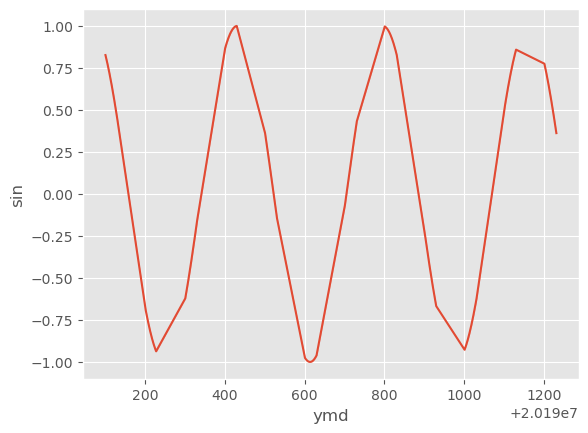

In [40]:
sns.lineplot(data=x_train, x="ymd", y = "sin")


<Axes: xlabel='ymd', ylabel='cos'>

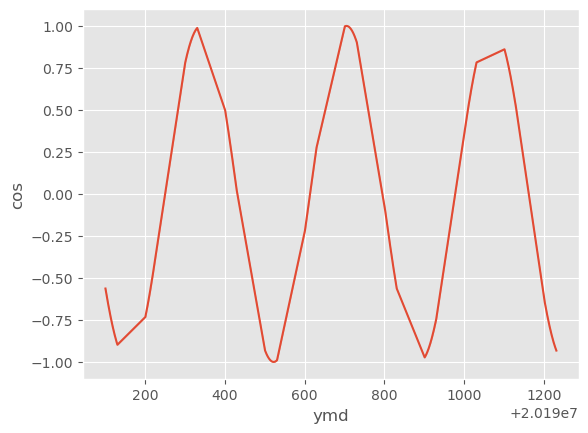

In [41]:
sns.lineplot(data=x_train, x="ymd", y = "cos")

In [42]:
x_train

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,LAT,LON,week,Mon,Tue,Wed,Thur,Fri,Sat,Sun,distance,isweekday,spring,summer,fall,winter,month,hour,year,dayofweek,quarter,dayofmonth,weekofyear,day,weekday,Monday,Tuesday,Wednesday,Thursday,Friday,ymd,sin,cos,spline_0,spline_1,spline_2,spline_3,spline_4,spline_5,spline_6,spline_7,spline_8,spline_9,spline_10,spline_11,spline_12,spline_13,spline_14,spline_15,spline_16,spline_17,spline_18,spline_19,spline_20,spline_21,spline_22,spline_23,spline_24,spline_25,spline_26,spline_27,spline_28,spline_29,spline_30,spline_31,spline_32,spline_33,spline_34,spline_35,spline_36,spline_37,spline_38,spline_39,spline_40,spline_41,spline_42,spline_43,spline_44,spline_45,spline_46,spline_47,spline_48,spline_49,spline_50,spline_51,spline_52,spline_53,spline_54,spline_55,spline_56,spline_57,spline_58,spline_59,V1_2_6,V3_4_5,1_/_V_1,V_1_square_2
0,0.464390,-2.844192,647.669067,303.707458,0.7557,98.452492,0.836825,89,0.350000,3,0.056600,2.058981,237.326815,28.0950,116.9622,0.653846,0,1,0,0,0,0,0,0.634615,1,0,1,0,0,8,0,2019,1,3,20,34,20,2,0,1,0,0,0,20190820,0.917584,-0.397543,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.072690,952.132226,2.148735,0.215658
1,0.353248,-0.269249,319.740570,278.104065,0.2426,102.246086,0.773377,40,32.419998,13,0.000266,2.604919,76.872996,35.4280,116.6305,0.961538,0,0,0,1,0,0,0,0.947802,1,0,0,0,1,12,0,2019,3,4,12,50,12,4,0,0,0,1,0,20191212,0.642055,-0.766659,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.330085,598.087235,2.822881,0.124784
2,0.217054,-3.203711,410.029419,295.771332,0.4007,95.362344,0.818272,366,30.200001,12,0.005800,2.404734,235.531159,30.1506,104.6356,0.269231,0,0,0,0,0,0,1,0.263736,0,1,0,0,0,4,0,2019,6,2,7,14,7,7,0,0,0,0,0,20190407,0.914128,0.405426,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.375686,706.201451,4.586030,0.047112
3,0.332295,-1.231481,595.750732,285.615051,0.3063,101.249391,0.789055,90,45.349998,13,0.003160,0.060650,159.524072,22.8225,108.3210,0.942308,1,0,0,0,0,0,0,0.920330,1,0,0,0,1,12,0,2019,0,4,2,49,2,1,1,0,0,0,0,20191202,0.763889,-0.645348,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.350205,881.672084,3.000345,0.110420
4,0.462568,-1.437667,790.363586,304.423859,0.3450,96.466047,0.828973,377,25.780001,12,3.821720,2.643497,318.380560,35.1147,111.0414,0.538462,0,0,0,0,0,0,1,0.532967,0,0,1,0,0,7,0,2019,6,3,14,28,14,7,0,0,0,0,0,20190714,0.154309,0.988023,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.166667,0.666667,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000

In [ ]:
sns.lineplot(data=x_train, x="ymd", y = "sin")

In [77]:
params = {"random_state":42,
          'early_stopping_rounds':1000,
          'iterations': 20000,
        
        'depth': 8,

          }

In [78]:
train_df.shape

(9737, 112)

In [79]:
test_df.shape

(3250, 111)

In [80]:
folds = 5

unseen_preds=[]
models = []
rmses = []


kf = KFold(n_splits=folds, shuffle=True, random_state=42)       



for train_index, valid_index in kf.split(x_train):
    

    x_train_cv = x_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    x_valid_cv = x_train.iloc[valid_index]
    y_valid_cv = y_train.iloc[valid_index]

    model = CatBoostRegressor(**params)

    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        #early_stopping_rounds = 1000, 
        verbose = 5000, 
    )
    y_pred_valid = model.predict(x_valid_cv)      
    unseen_preds.append(y_pred_valid)
    temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_cv, y_pred_valid))

    print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')
    

    rmses.append(temp_rmse_valid)

print(f'RMSE(valid_data)_mean = {np.array(rmses).mean():.4f}')
print(f'RMSE(valid_data)_std = {np.array(rmses).std():.4f}')

Learning rate set to 0.011304
0:	learn: 28.0358803	test: 28.0358803	test1: 26.9745667	best: 26.9745667 (0)	total: 74.4ms	remaining: 24m 48s
5000:	learn: 6.0110481	test: 6.0110481	test1: 13.8453862	best: 13.8453862 (5000)	total: 29.4s	remaining: 1m 28s
10000:	learn: 3.0908576	test: 3.0908576	test1: 13.6525102	best: 13.6524146 (9997)	total: 58.1s	remaining: 58.1s
15000:	learn: 1.7848818	test: 1.7848818	test1: 13.6141829	best: 13.6141625 (14994)	total: 1m 26s	remaining: 29s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 13.61247447
bestIteration = 15253

Shrink model to first 15254 iterations.
RMSE(valid_data) = 13.6125

Learning rate set to 0.011304
0:	learn: 27.5893322	test: 27.5893322	test1: 28.7570907	best: 28.7570907 (0)	total: 15.5ms	remaining: 5m 9s
5000:	learn: 5.9455968	test: 5.9455968	test1: 14.8382760	best: 14.8379989 (4995)	total: 28.7s	remaining: 1m 26s
10000:	learn: 3.0379689	test: 3.0379689	test1: 14.5815784	best: 14.5815383 (9997)	total: 57.6s	remainin

KeyboardInterrupt: 

In [ ]:
rmses

In [ ]:
from catboost import CatBoostRegressor


 
 chmaxdepth 8
 
RMSE(valid_data)_mean = 14.5773
RMSE(valid_data)_std = 0.7207

[13.827182563494912,
 15.11508733297057,
 14.118133057214884,
 14.199584963252665,
 15.68433608229355]
 
 RMSE(valid_data)_mean = 14.3108
RMSE(valid_data)_std = 0.4630

[13.822638403808647,
 14.662830535473633,
 14.009918636479004,
 15.040978359183919,
 14.017392007476582]

RMSE(valid_data)_mean = 14.3210
RMSE(valid_data)_std = 0.4777

[13.839101630814174,
 14.701033083826218,
 14.013691499936174,
 15.066938364881509,
 13.984026543793606]
 
 RMSE(valid_data)_mean = 14.2646
RMSE(valid_data)_std = 0.4525
 
 [13.798150662812331,
 14.545167914070186,
 14.013075354136069,
 15.016518198376392,
 13.95027081319474]
 
RMSE(valid_data)_mean = 14.0407
RMSE(valid_data)_std = 0.4400

[13.63963230968322,
 14.366261128422632,
 13.791849659937855,
 14.744383840101472,
 13.661326593564276]
 
 RMSE(valid_data)_mean = 14.0404
RMSE(valid_data)_std = 0.4225

[13.534868984383023,
 14.330993409697266,
 13.881413113384726,
 14.705444799359412,
 13.74919138985025]

In [ ]:
[13.568719867161729,
 14.359696559196909,
 13.847052708323494,
 14.759198888169013,
 13.73156342587145]

In [ ]:
model = CatBoostRegressor(**params)

model.fit(
    x_train, 
    y_train, 
    
    #early_stopping_rounds = 1000, 
    verbose = 5000, 
)
y_pred_valid =  model.predict(x_test)

In [ ]:
#submission["POWER"] = pred
submission["POWER"] = y_pred_valid

In [ ]:
submission

In [ ]:
#submission.to_csv("sub_with_base_features_lgbm_no_hypo.csv",index=False) # 17.11
submission.to_csv("sub_datetime_feats_outlierfeats_add_deal_DATE_spline30_latlontwo_transformfeats.csv",index=False)